In [1]:
# The key idea is to use FFT to transform the data to make it easier to train

# Real -> Real.FFT, Img -> Img.FFT
# Amp -> Amp.FFT, Phase -> Phase.FFT

In [2]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import r2_score

import MLP
import data_parser

In [3]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

df = data_parser.calculate_amp_phase(data_parser.data_parse(), unwrap=True)

CUDA avaiable


In [4]:
def plot_X_y(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
             figname=None, savefig=False):
    
    # Plot a 3x3 figure
    line = 7
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)

    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy())
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy())
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
        
    plt.show();

In [5]:
models = {}
predictions = {}

# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))
random.seed(42)
np.random.shuffle(index_list)

# Split the indices into 80% training set, 10% testing set and 10% validation set
indices = {}
indices['train_idx'] = index_list[:int(len(index_list) * 0.8)]
indices['val_idx'] = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
indices['test_idx'] = index_list[int(len(index_list) * 0.9):]

input_cols = ["W", "Trap", "Length"]

in_features = 3
out_features = 501

# Define F for plot
F = torch.Tensor(df.loc[indices['train_idx'][0]]['F']).reshape(-1, 1)

In [6]:
output_col = 'A(1,1)'
df[output_col+'_FFT_R'] = np.zeros_like(df[output_col])
df[output_col+'_FFT_I'] = np.zeros_like(df[output_col])

for example_idx in index_list:
    g = np.fft.fft(df.loc[example_idx][output_col])
    df.loc[example_idx][output_col+'_FFT_R'] = g.real
    df.loc[example_idx][output_col+'_FFT_I'] = g.imag

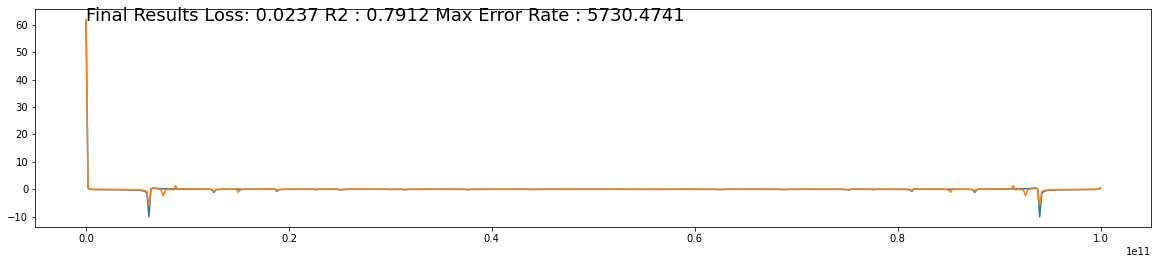

In [13]:
output_col = 'A(1,1)_FFT_R'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 20000)
predictions[output_col] = models[output_col].test()

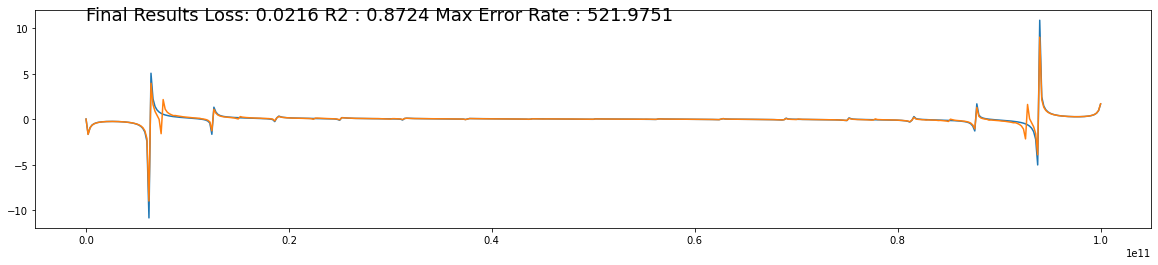

In [12]:
output_col = 'A(1,1)_FFT_I'
models[output_col] = MLP.Model(df, indices, input_cols, output_col, in_features, out_features, device)
models[output_col].train(0.001, 20000)
predictions[output_col] = models[output_col].test()

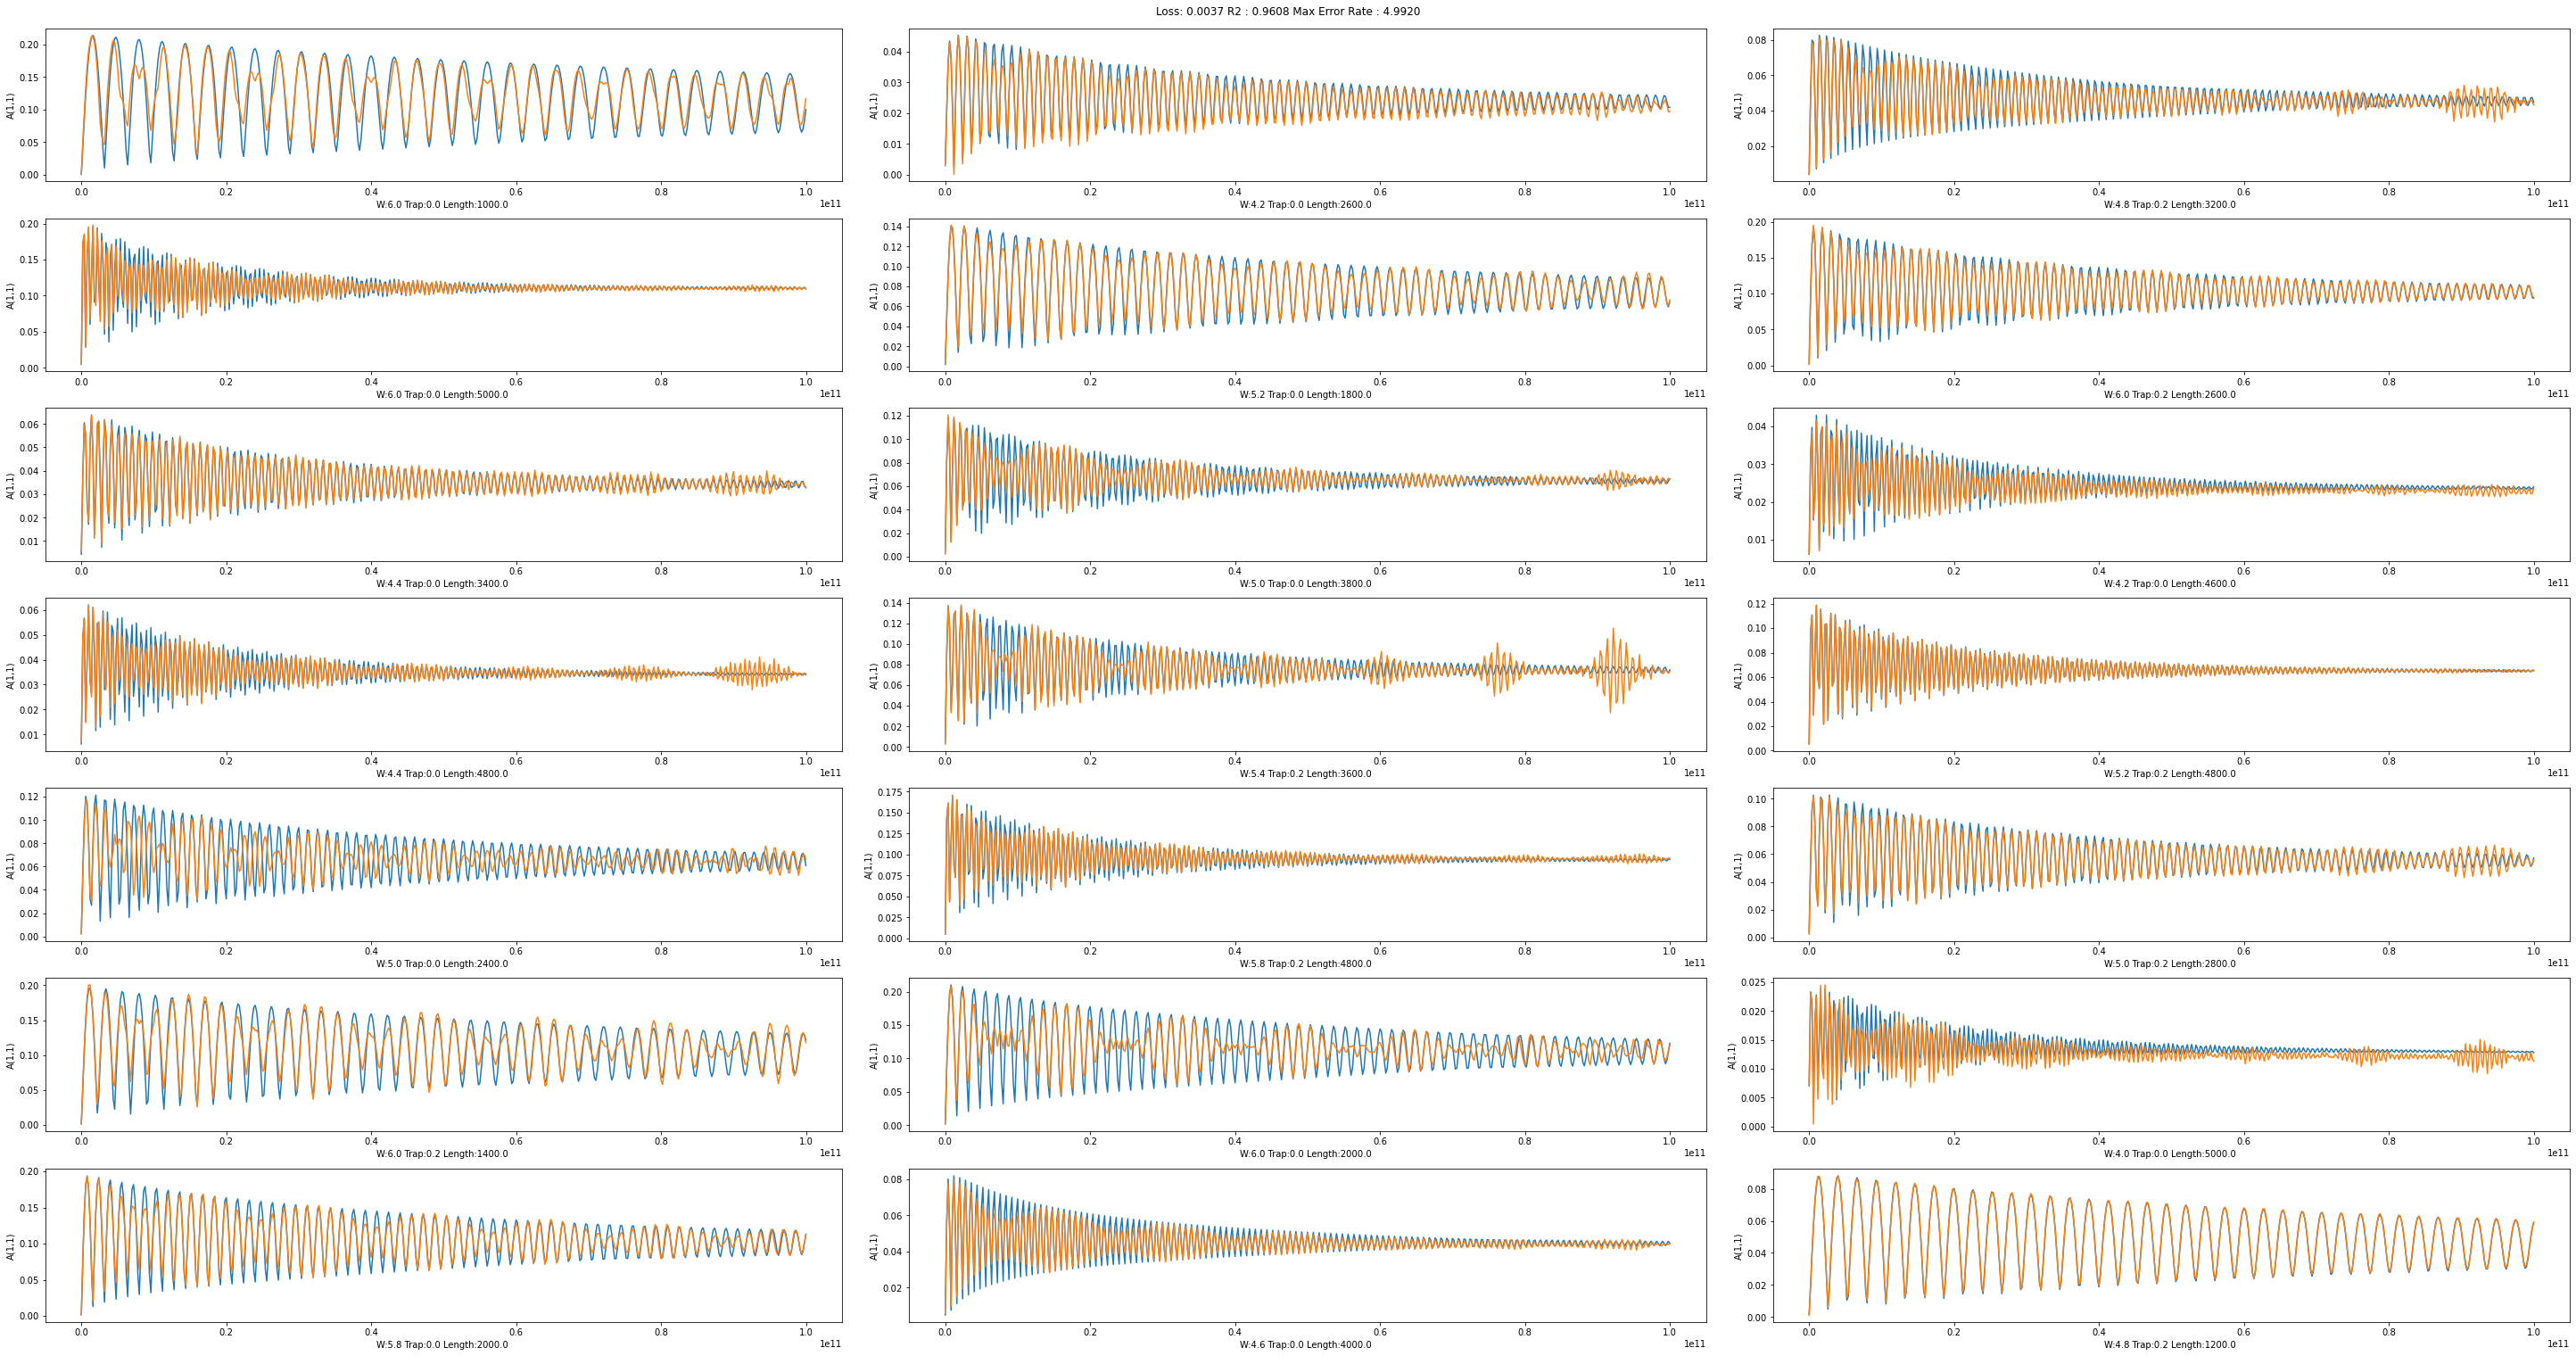

In [14]:
# A(1,1)
predictions['A(1,1)_FFT'] = predictions['A(1,1)_FFT_R'] + predictions['A(1,1)_FFT_I'] * 1j
predictions['A(1,1)'] = torch.abs(torch.fft.ifft(predictions['A(1,1)_FFT'], dim=-1))
y_test = torch.Tensor(df.loc[indices['test_idx']]['A(1,1)'].to_numpy().reshape(-1, 501)).to(device)

criterion = nn.L1Loss()
test_loss = criterion(predictions['A(1,1)'], y_test)
r2 = r2_score(predictions['A(1,1)'].detach().cpu().numpy(), y_test.detach().cpu().numpy())
mer = torch.max(torch.abs(predictions['A(1,1)'] - y_test) / y_test)

plot_X_y(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, 'A(1,1)', predictions['A(1,1)'].cpu(), \
         test_loss, r2, mer, figname='A(1,1)', savefig=True)

In [53]:
predictions['A(1,1)_FFT']

tensor([[ 6.5261e+00+1.7978e-16j,  1.0550e-01-2.7169e-01j,
          2.0216e-02-1.6658e-01j,  ...,
         -1.6107e-03+1.1134e-01j,  1.8494e-02+1.6802e-01j,
          1.1531e-01+2.8104e-01j],
        [ 4.8325e+01+1.7993e-15j,  6.6525e-01-7.5041e-01j,
          2.6655e-01-5.9660e-01j,  ...,
          1.2119e-01+4.5514e-01j,  2.6530e-01+5.9190e-01j,
          6.6308e-01+7.6511e-01j],
        [ 1.9072e+01+7.3466e-16j,  2.3965e-01-5.8927e-01j,
          4.8721e-02-3.4109e-01j,  ...,
          1.1284e-03+2.3988e-01j,  4.8479e-02+3.5190e-01j,
          2.3897e-01+5.7880e-01j],
        ...,
        [ 3.3094e+01+1.0449e-15j,  3.7653e-01-3.7168e-01j,
          1.8288e-01-3.2166e-01j,  ...,
          9.1809e-02+2.6649e-01j,  1.8150e-01+3.1754e-01j,
          3.7493e-01+3.7650e-01j],
        [ 1.8281e+01+6.5130e-16j,  2.6645e-01-4.7638e-01j,
          7.4402e-02-3.0940e-01j,  ...,
          1.8379e-02+2.2536e-01j,  7.3485e-02+3.1160e-01j,
          2.6604e-01+4.8122e-01j],
        [ 2.9166e+01+9

In [14]:
S = df.loc[example_idx]['SR(1,1)'] + df.loc[example_idx]['SI(1,1)'] * 1j


In [20]:
g.shape

(501,)